# Question 2

In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import imageio
import seaborn as sns

<h3>2a) implemetation of value and policy iteration</h3>

<h2><center> Value Iteration </center></h2>

<img src = "valueiteration.png" width = 500 >

<p>Implemented both value iteration and policy iteration for value iteration it has a flag called is_falls to generalize this  for the custom environment also both classes has policy plot functions embedded into them</p>

In [2]:
class valueiteration():        
    def __init__(self,env,gridlength,max_epochs = 1000,epsilon = 1e-6,is_walls = False):
        self.env = env
        self.max_epochs = max_epochs
        self.epsilon = epsilon
        self.state_value = np.zeros(env.observation_space.n)
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.is_walls = is_walls
        self.walls = []
        if is_walls:
            self.walls = env.walls
        self.gridlength = gridlength
        self.terminal_states = set()
        self.find_terminal(env)

    def find_terminal(self,env):
        for state in range(env.observation_space.n):
            if self.is_walls:
                if state in self.walls:
                    continue
            for action in range(env.action_space.n):
                transitions = env.P[state][action]
                for prob, next_state, reward, terminal in transitions:
                    if terminal:
                        self.terminal_states.add(next_state)

    def retrieve_policy(self,gamma):
        #given optimal value_function we can find optimal policy  can be many
        optimal_action = np.random.randint(0, self.num_actions, size=self.num_states)
        for i in range(self.num_states):
            if self.is_walls:
                if i in self.walls:
                    continue
            actions = np.zeros(self.num_actions)
            for j in range(self.num_actions):
                gain = 0
                for k in self.env.P[i][j]:
                    gain += k[0]*(k[2] + gamma*self.state_value[k[1]])
                actions[j] = gain
            optimal_action[i] = np.argmax(actions)
        policy = optimal_action
            
        arrow_grid = np.zeros((self.gridlength,self.gridlength), dtype=int)
        for state in range(len(policy)):
            action = policy[state]
            if (state in self.terminal_states) or (state in self.walls):
                action = -1
            row, col = divmod(state,self.gridlength)
            if action == 0:  # Move left
                arrow_grid[row, col] = 1
            elif action == 1:  # Move down
                arrow_grid[row, col] = 2
            elif action == 2:  # Move right
                arrow_grid[row, col] = 3
            elif action == 3:  # Move up
                arrow_grid[row, col] = 4
        temp = self.state_value.copy() 
        sns.heatmap(temp.reshape(self.gridlength,self.gridlength), cmap='Blues', annot=True, fmt='.2f')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.title(f'Optimal Policy for gamma:{gamma}')
        for i in range(self.gridlength):
            for j in range(self.gridlength):
                if arrow_grid[i, j] == 1:  # Left arrow
                    plt.arrow(j + 0.5, i + 0.5, -0.4, 0, head_width=0.15, head_length=0.15, fc='black', ec='black')
                elif arrow_grid[i, j] == 2:  # Down arrow
                    plt.arrow(j + 0.5, i + 0.5, 0, 0.4, head_width=0.15, head_length=0.15, fc='black', ec='black')
                elif arrow_grid[i, j] == 3:  # Right arrow
                    plt.arrow(j + 0.5, i + 0.5, 0.4, 0, head_width=0.15, head_length=0.15, fc='black', ec='black')
                elif arrow_grid[i, j] == 4:  # Up arrow
                    plt.arrow(j + 0.5, i + 0.5, 0, -0.4, head_width=0.15, head_length=0.15, fc='black', ec='black')
        plt.show()
        return policy
    
    def retrieve_stochastic_policy(self, gamma):
        optimal_action = [0] * self.num_states
        temp = self.state_value.copy()
        arrow_grid = [[[] for _ in range(self.gridlength)] for _ in range(self.gridlength)]

        for state in range(self.num_states):
            if state in self.terminal_states:
                optimal_action[state] = []
                continue
            if self.is_walls:
                if state in self.walls:
                    continue
            actions = np.zeros(self.num_actions)
            for action in range(self.num_actions):
                gain = 0
                for transition in self.env.P[state][action]:
                    probability, next_state, reward, _ = transition
                    gain += probability * (reward + gamma * self.state_value[next_state])
                actions[action] = gain
            max_gain = np.max(actions)
            max_actions = np.where(actions == max_gain)[0]
            optimal_action[state] = max_actions.tolist()

            row, col = divmod(state, self.gridlength)
            if state not in self.terminal_states and state not in self.walls:
                arrow_grid[row][col] = max_actions.tolist()
                
        sns.heatmap(temp.reshape(self.gridlength, self.gridlength), cmap='Blues', annot=True, fmt='.2f')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.title(f'Optimal Policy for gamma: {gamma}')
        for i in range(self.gridlength):
            for j in range(self.gridlength):
                for direction in arrow_grid[i][j]:
                    if direction == 0:  # Move left
                        plt.arrow(j + 0.5, i + 0.5, -0.4, 0, head_width=0.15, head_length=0.15, fc='black', ec='black')
                    elif direction == 1:  # Move down
                        plt.arrow(j + 0.5, i + 0.5, 0, 0.4, head_width=0.15, head_length=0.15, fc='black', ec='black')
                    elif direction == 2:  # Move right
                        plt.arrow(j + 0.5, i + 0.5, 0.4, 0, head_width=0.15, head_length=0.15, fc='black', ec='black')
                    elif direction == 3:  # Move up
                        plt.arrow(j + 0.5, i + 0.5, 0, -0.4, head_width=0.15, head_length=0.15, fc='black', ec='black')
        plt.show()
        return optimal_action
    
    def iteration(self,gamma):
        initial = self.state_value.copy()
        for i in range(self.num_states):
            if self.is_walls:
                if i in self.walls:
                    continue
            temp = self.state_value[i]
            actions = np.zeros(self.num_actions)
            for j in range(self.num_actions):
                for k in self.env.P[i][j]: # each k is a tuple (prob,state,reward,terminal)
                    actions[j] += k[0]*(k[2] + gamma*self.state_value[k[1]])
            self.state_value[i] = np.max(actions) #update statement 
        return np.linalg.norm(initial - self.state_value)
                         
    def train(self,gamma):
        error = []
        delta = self.iteration(gamma)
        epochs = 1
        error.append(delta)
        while delta > self.epsilon and epochs < self.max_epochs:
            delta = self.iteration(gamma)
            epochs += 1
            error.append(delta)
            
        #plotting convergence
        print(f'Noof epochs {epochs}')
        plt.figure(figsize=(4, 4))
        x_vals = range(epochs)
        plt.plot(x_vals, error)
        plt.xlabel('Epochs')
        plt.ylabel('norm of change in state value')
        plt.grid()
        plt.title(f'Error Convergence with gamma as {gamma}')
        plt.show() 
        return self.retrieve_policy(gamma)
        

<h2><center> Policy Iteration </center></h2>

<img src = "policy_iteration.webp" width = 500 >

In [3]:
class policy_iteration:
    def __init__(self, env, gridlength, max_epochs=1000, epsilon=1e-6):
        self.env = env
        self.max_epochs = max_epochs
        self.epsilon = epsilon
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.gridlength = gridlength
        self.terminal_states = set()
        self.find_terminal(env)

    def find_terminal(self, env):
        for state in range(env.observation_space.n):
            for action in range(env.action_space.n):
                transitions = env.P[state][action]
                for prob, next_state, reward, terminal in transitions:
                    if terminal:
                        self.terminal_states.add(next_state)

    def policy_eval(self, policy, gamma):
        
        val_fun = np.zeros(self.num_states)
        for noof_epoch in range(self.max_epochs):
            initial = val_fun.copy()
            for state in range(self.num_states):
                action = policy[state]
                initial = val_fun[state].copy()
                temp = 0.0
                for prob, next_state, reward, terminal in self.env.P[state][action]:
                    temp += prob *(reward + gamma * val_fun[next_state])
                val_fun[state] = temp
            norm_diff = np.linalg.norm(val_fun - initial)
            if norm_diff < self.epsilon:
                break
        return val_fun

    def policy_improvement(self, policy, value_fun, gamma):
        new_policy = np.random.randint(0, self.num_actions, size=self.num_states)
        for state in range(self.num_states):
            Q_vals = np.zeros(self.num_actions)  # vector of q values
            for action in range(self.num_actions):
                for prob, next_state, reward, done in self.env.P[state][action]:
                    Q_vals[action] += prob * (reward + gamma * value_fun[next_state])

            # Update the policy
            optimal_action = np.argmax(Q_vals)
            new_policy[state] = optimal_action  # greedy action
        return new_policy

    def plot_policy_with_arrows(self,policy,value_function,grid_size,gamma):
        arrow_grid = np.zeros((grid_size, grid_size), dtype=int)
        for state in range(len(policy)):
            action = policy[state]
            if state in self.terminal_states:
                action = -1
            row, col = divmod(state, grid_size)
            if action == 0:  # Move left
                arrow_grid[row, col] = 1
            elif action == 1:  # Move down
                arrow_grid[row, col] = 2
            elif action == 2:  # Move right
                arrow_grid[row, col] = 3
            elif action == 3:  # Move up
                arrow_grid[row, col] = 4
        sns.heatmap(value_function.reshape(grid_size,grid_size), cmap='Blues', annot=True, fmt='.2f')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.title(f'Optimal Policy for gamma:{gamma}')
        for i in range(grid_size):
            for j in range(grid_size):
                if arrow_grid[i, j] == 1:  # Left arrow
                    plt.arrow(j + 0.5, i + 0.5, -0.4, 0, head_width=0.15, head_length=0.15, fc='black', ec='black')
                elif arrow_grid[i, j] == 2:  # Down arrow
                    plt.arrow(j + 0.5, i + 0.5, 0, 0.4, head_width=0.15, head_length=0.15, fc='black', ec='black')
                elif arrow_grid[i, j] == 3:  # Right arrow
                    plt.arrow(j + 0.5, i + 0.5, 0.4, 0, head_width=0.15, head_length=0.15, fc='black', ec='black')
                elif arrow_grid[i, j] == 4:  # Up arrow
                    plt.arrow(j + 0.5, i + 0.5, 0, -0.4, head_width=0.15, head_length=0.15, fc='black', ec='black')
        plt.show()

    def train(self, gamma):
        policy = np.random.randint(0, self.num_actions, size=self.num_states)
        converged = False
        epochs = 0
        while not converged and epochs < self.max_epochs:
            value_fun = self.policy_eval(policy, gamma)
            new_policy = self.policy_improvement(policy, value_fun, gamma)
            if np.array_equal(new_policy, policy):
                converged = True
            else:
                policy = new_policy

            epochs += 1
        print(f'Noof epochs:{epochs}')
        return policy,self.policy_eval(policy,gamma)

<h3> 2b) analysis of algorithm </h3>

Noof epochs 242


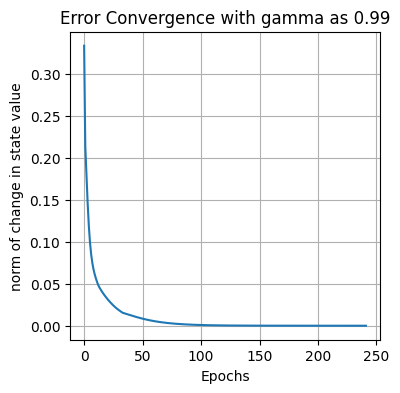

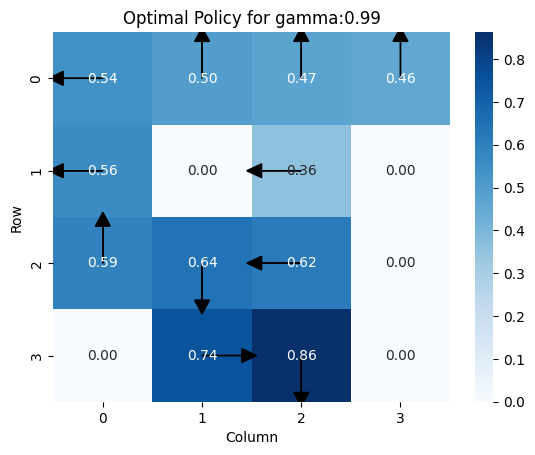

In [4]:
######### value iteartion

env = gym.make('FrozenLake-v1',desc = None,render_mode = 'rgb_array',is_slippery=True)
env.reset()
model = valueiteration(env,4)
policy = model.train(0.99)

frames = []
env.reset()
done = False
state = 0
while not done:
    action = policy[state]  # Replace with your agent's action selection logic
    next_state, _, done, _,_ = env.step(action)
    frame = env.render()
    frames.append(frame)
    state = next_state

env.close()

imageio.mimsave('frozen_lake_animation_value_iter.gif', frames, duration=0.1)

<p>We used is_slippary = True ie stochastic environment and gamma = 0.99</p>

* we used heat maps to plot the final value function and at each state we showed the optimal action to take inorder to maximize the discounted reward
* the cell with no actions are terminal states or in latter custom environment they are walls
* It took 242 epochs for value iteration to converge with tolerance at 1e-6</p>
* It took 7 epochs for policy iteration to converge with tolerance at 1e-6.But we much also consider the fact that in policy iteration each epoch cooresponds to policy evalution + policy improvement so during policy evaluation we evaluate untill the norm of difference of value funtion is less than the desired tolerance so this may take many iterations to happen</p>

<p>After findind the optimal policy  we ran the agent on that policy in frozen lake and renderd using 
rgb_array and each frame is stored and made into a gif for visualization below is for policy iteration</p>

<p>Below is an gif for agent under optimal policy found by value iteration </p>

* if the below image is not loaded rerun the cell as it is markdown environmet

<img src = "frozen_lake_animation_value_iter.gif" width = 200 >

Noof epochs:6


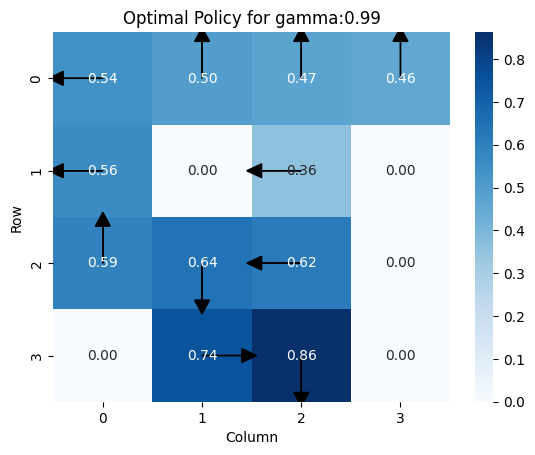

In [5]:
########### Policy iteration

env.reset()
model = policy_iteration(env,4)
policy,value_function = model.train(0.99)
model.plot_policy_with_arrows(policy,value_function,4,0.99)

frames = []
env.reset()
done = False
state = 0
while not done:
    action = policy[state]  # Replace with your agent's action selection logic
    next_state,_,done, _,_ = env.step(action)
    frame = env.render()
    frames.append(frame)
    state = next_state
env.close()

imageio.mimsave('frozen_lake_animation_policy_iter.gif', frames, duration=0.1)

 <img src = "frozen_lake_animation_policy_iter.gif" width = 200 >

<h3> 2c) stochastic optimal policies </h3>

<p>After analysing the above is_slippery = True ie stochastic environment there
is no stochastic environmet(in the sense that at every state we have only one optimal action) so we used is_slippary = False then we can observe there is infact stochastic policy cause if we observe the value function plot we see in some cells the neighbours have same  value functions then due to deterministic nature we get same Q_value_functions and hence we have multiple options to choose from and we showed that in the heatmap.If any state has one or more optimal actions we included multiple arrows meaning they can take any of the two actions but the probalility distribution must sum upto 1 for all actions in all states</p>

<p>To extract stochastic policy what we need to do is in place of argmax if 2 or more actions leads to 
same Q-value function then it does matter which state we take in determinstic policy extraction np.argmax only selects one but here we exract all the maximum and put it in list and plot the arrows</p>

Noof epochs 7


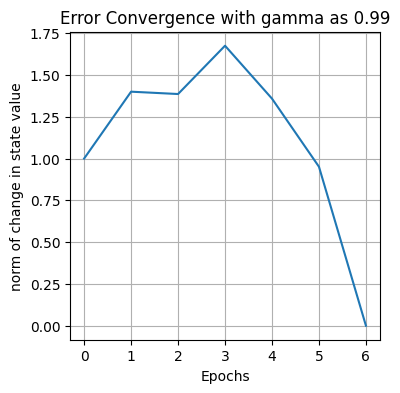

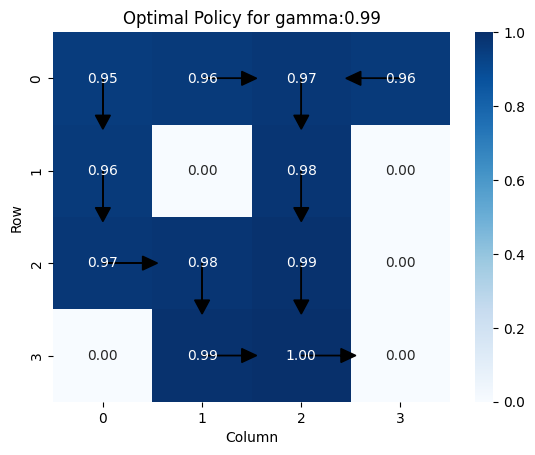

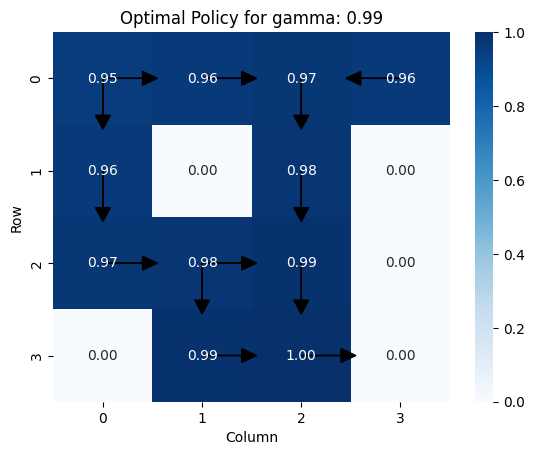

[[1, 2], [2], [1], [0], [1], [], [1], [], [2], [1, 2], [1], [], [], [2], [2], []]


In [6]:
######### Deterministic environment iteartion

env = gym.make('FrozenLake-v1',desc = None,render_mode = 'rgb_array',is_slippery = False)
env.reset()
model = valueiteration(env,4)
policy = model.train(0.99)

stochastic_policy = model.retrieve_stochastic_policy(0.99)
print(stochastic_policy)
frames = []
env.reset()
done = False
state = 0
while not done:
    action = random.choice(stochastic_policy[state])  # Replace with your agent's action selection logic
    next_state, _, done, _,_ = env.step(action)
    frame = env.render()
    frames.append(frame)
    state = next_state

env.close()

imageio.mimsave('frozen_lake_animation_deterministic_value_iter.gif', frames, duration=0.1)

* above we ploted stochastic policy and 1 determisnistic policy possible from that stochastic policy
* for this stochastic policy we select action according the policy distribution and ran a simulation

<img src = "frozen_lake_animation_deterministic_policy_iter.gif" width = 200 >

Noof epochs:7


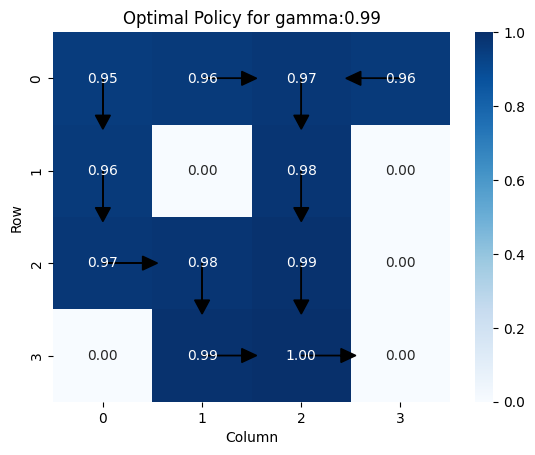

In [7]:
########### deterministic environment Policy iteration

env.reset()
model = policy_iteration(env,4)
policy,value_function = model.train(0.99)
model.plot_policy_with_arrows(policy,value_function,4,0.99)

frames = []
env.reset()
done = False
state = 0
while not done:
    action = policy[state]  # Replace with your agent's action selection logic
    next_state, _, done, _,_ = env.step(action)
    frame = env.render()
    frames.append(frame)
    state = next_state
env.close()

imageio.mimsave('frozen_lake_animation_deterministic_policy_iter.gif', frames, duration=0.1)

<img src = "frozen_lake_animation_deterministic_policy_iter.gif" width = 200 >

<p>Above did the same with policy iteration in determinstic environment</p>

<h3> Custom environment  </h3>

<img src = "customenv.png" width = 350 >

In [8]:
######## (i) implementaion 

class CustomEnv(gym.Env):
    def __init__(self,eta):
        super(CustomEnv, self).__init__()
        self.grid_size = 5
        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4) 
        self.start_state = 15
        self.terminal_states = []
        self.walls = [6, 11, 13]
        self.rewards_states = {}
        for state in range(self.grid_size * self.grid_size):
            self.rewards_states[state] = 0
        self.rewards_states[12] = 1
        self.rewards_states[14] = 10
        for i in range(5):
            self.terminal_states.append(i + 20)
            self.rewards_states[i + 20] = -10
        self.transition_prob = eta
        self.action_to_direction = {
            0: np.array([0, -1]),  # Left
            1: np.array([1, 0]),   # Down
            2: np.array([0, 1]),   # Right
            3: np.array([-1, 0])   # Up
        }
        self.state = self.start_state
        self.P = self.initialize_prob()

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        direction = self.action_to_direction[action]
        intended_state = self.state + direction
        if intended_state in self.terminal_states:
            reward = self.rewards_states[intended_state]
            done = True
        else:
            reward = 0
            done = False
        
        # Simulate stochasticity with transition_prob
        if random.uniform(0, 1) > self.transition_prob:
            next_state = self.state
        else:
            next_state = intended_state

        self.state = next_state
        return next_state, reward, done, {}

    def render(self):
        grid = []
        for _ in range(self.grid_size):
            row = ['_' for _ in range(self.grid_size)]
            grid.append(row)
        for terminal_state, reward in self.rewards_states.items():
            grid[terminal_state // self.grid_size][terminal_state % self.grid_size] = str(reward)
        grid[self.state // self.grid_size][self.state % self.grid_size] = 'X'
        for row in grid:
            print(' '.join(row))
        print()

    def initialize_prob(self):
        num_states = self.observation_space.n
        num_actions = self.action_space.n
        P = {}
        for state in range(num_states):
            if state in self.walls:
                continue
            P[state] = {}
            for action in range(num_actions):
                P[state][action] = self.calc_tuple(state, action)
        return P
    
    def check_validity(self, state, action):
        i = state // self.grid_size + self.action_to_direction[action][0]
        j = state % self.grid_size + self.action_to_direction[action][1]
        if (i * self.grid_size + j) in self.walls:
            return False
        return i < self.grid_size and j < self.grid_size and i >= 0 and j >= 0

    def calc_tuple(self, state, action):
        ls = []
        if state in self.terminal_states:
            ls.append((1.0, state, 0, True))
        else:
            for actions in range(self.action_space.n):
                intended_state = state
                if self.check_validity(state,actions):
                    intended_state=state+self.action_to_direction[actions][0]*self.grid_size+self.action_to_direction[actions][1]
    
                if actions == action:
                    ls.append((0.8, intended_state, self.rewards_states[intended_state], intended_state in self.terminal_states))
                else:
                    ls.append((0.2/3,intended_state,self.rewards_states[intended_state],intended_state in self.terminal_states))
        return ls


Noof epochs 1042


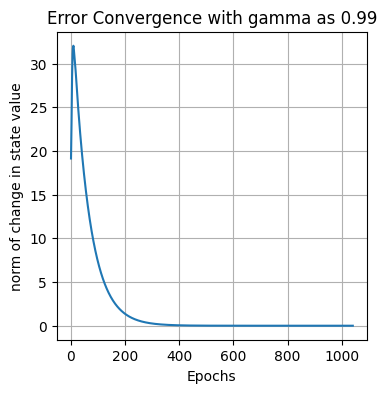

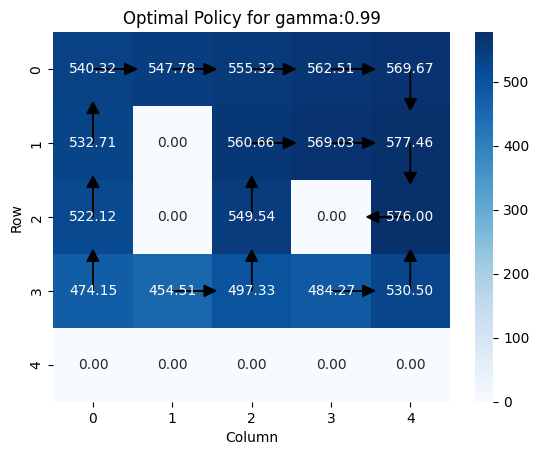

Noof epochs 11


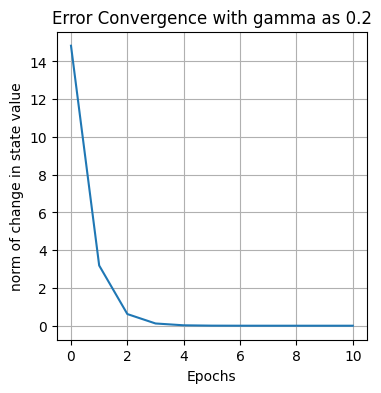

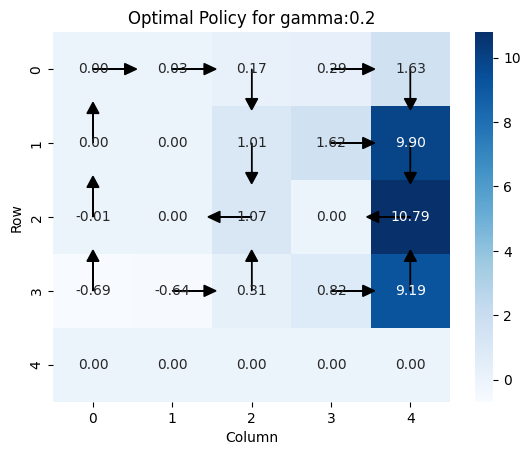

Noof epochs 1042


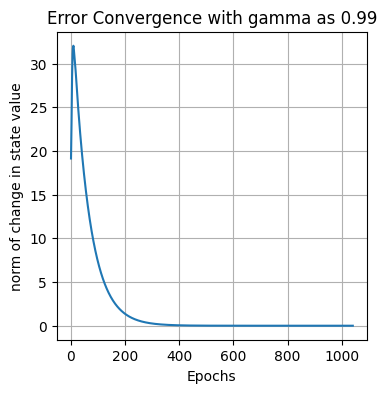

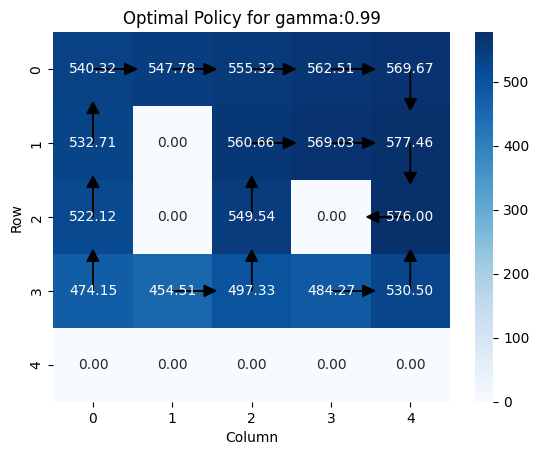

Noof epochs 11


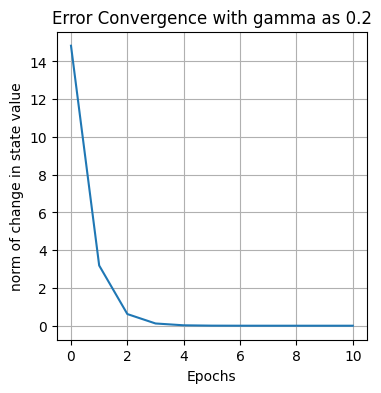

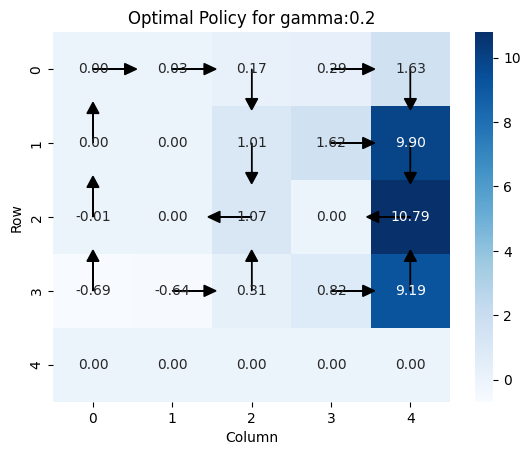

In [9]:
####### (ii) using above value iteariotn to solve the optimal paths

# eta = 0.8 gamma = 0.99
env = CustomEnv(0.8)
model = valueiteration(env,5,max_epochs = 2000,is_walls = True)
policy = model.train(0.99)


# eta = 0.8 gamma = 0.2
env = CustomEnv(0.8)
model = valueiteration(env,5,max_epochs = 2000,is_walls = True)
policy = model.train(0.2)


# eta = 0.9 gamma = 0.99
env = CustomEnv(0.5)
model = valueiteration(env,5,max_epochs = 2000,is_walls = True)
policy = model.train(0.99)


# eta = 0.9 gamma = 0.2
env = CustomEnv(0.5)
model = valueiteration(env,5,max_epochs = 2000,is_walls = True)
policy = model.train(0.2)

* we can see for the same eta value as gamma is small noof epochs required decreases due to face that we are optimizing for short term reward more it 
* we can see as the noice decreases our agent behaves more deterministically heance taking direct paths to the destinations
* for less gamma's in 3rd row we are taking a straight path due to short term reward optimization so down  -ve reward are not weighted that much 
* for large gamma's we see system taking one of the long paths that was asked to identify meaning the system is carefull about the long term -ve loss it suffers if it went on straight 3rd path


### optimal path depends on gamma

form the above we can see that the gamma is an integral part for the solution of the MDP 
* for the same environment (ie same eta) solving for optimal policies for two different gamma's gives the different optimal policies (Doest mean always we will get differnt but it cant be guarentted to get same)
